# 4-jina-embedding-v4 (vllm online)
* Adapter code from vllm example [link](https://github.com/vllm-project/vllm/blob/main/examples/online_serving/openai_chat_embedding_client_for_multimodal.py)
* discussions about embedding text+image / multiple images [hf discussions/38](https://huggingface.co/jinaai/jina-embeddings-v4/discussions/38)

vLLM encode
```
@overload
def encode(
    self,
    prompts: Union[PromptType, Sequence[PromptType]],
    /,
    pooling_params: Optional[Union[PoolingParams,
                                    Sequence[PoolingParams]]] = None,
    *,
    truncate_prompt_tokens: Optional[int] = None,
    use_tqdm: Union[bool, Callable[..., tqdm]] = True,
    lora_request: Optional[Union[list[LoRARequest], LoRARequest]] = None,
    prompt_adapter_request: Optional[PromptAdapterRequest] = None,
) -> list[PoolingRequestOutput]:
    ...
```

2 Types of Online OpenAI-Compatible EmbeddingRequest (v1/embeddings)
* EmbeddingCompletionRequest [link](https://github.com/vllm-project/vllm/blob/0ec3779df74ff68ab920856234e2a1aafc21f1a1/vllm/entrypoints/openai/protocol.py#L1070)
* EmbeddingChatRequest [link](https://github.com/vllm-project/vllm/blob/0ec3779df74ff68ab920856234e2a1aafc21f1a1/vllm/entrypoints/openai/protocol.py#L1106)

```
# EmbeddingChatRequest

```

## Offline vLLM Input Examples
* https://huggingface.co/jinaai/jina-embeddings-v4-vllm-retrieval
```
query = "Overview of climate change impacts on coastal cities"
query_prompt = TextPrompt(prompt=f"Query: {query}")

passage = "The impacts of climate change on coastal cities are significant.."
passage_prompt = TextPrompt(prompt=f"Passage: {passage}")

# Create image prompt
image = Image.open("<path_to_image>")
image_prompt = TextPrompt(
    prompt="<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe the image.<|im_end|>\n",
    multi_modal_data={"image": image},
)
```

In [1]:
import base64
from io import BytesIO

import requests
from PIL import Image

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
VLLM_ENDPOINT="http://localhost:8080"
MODEL="jina-embeddings-v4-vllm-retrieval"

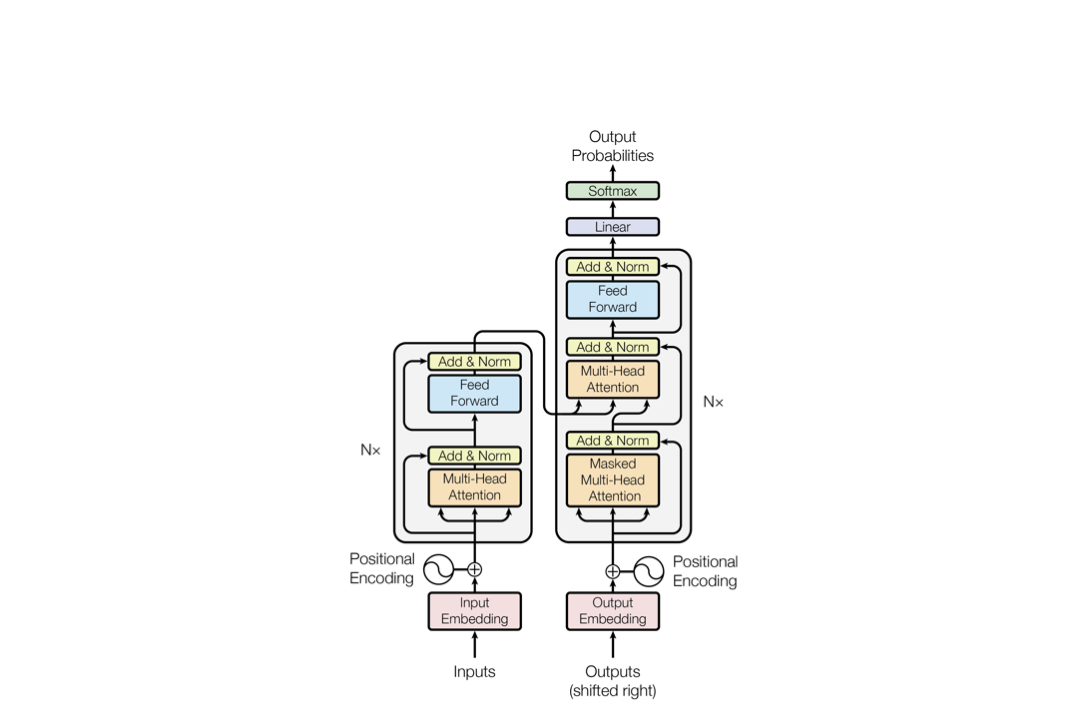

In [3]:
# Load Image
image = Image.open("../samples/1706.03762v7_p3.png").convert("RGB")
image
width, height = image.size
upper_half = image.crop((0, 0, width, height//2))
upper_half

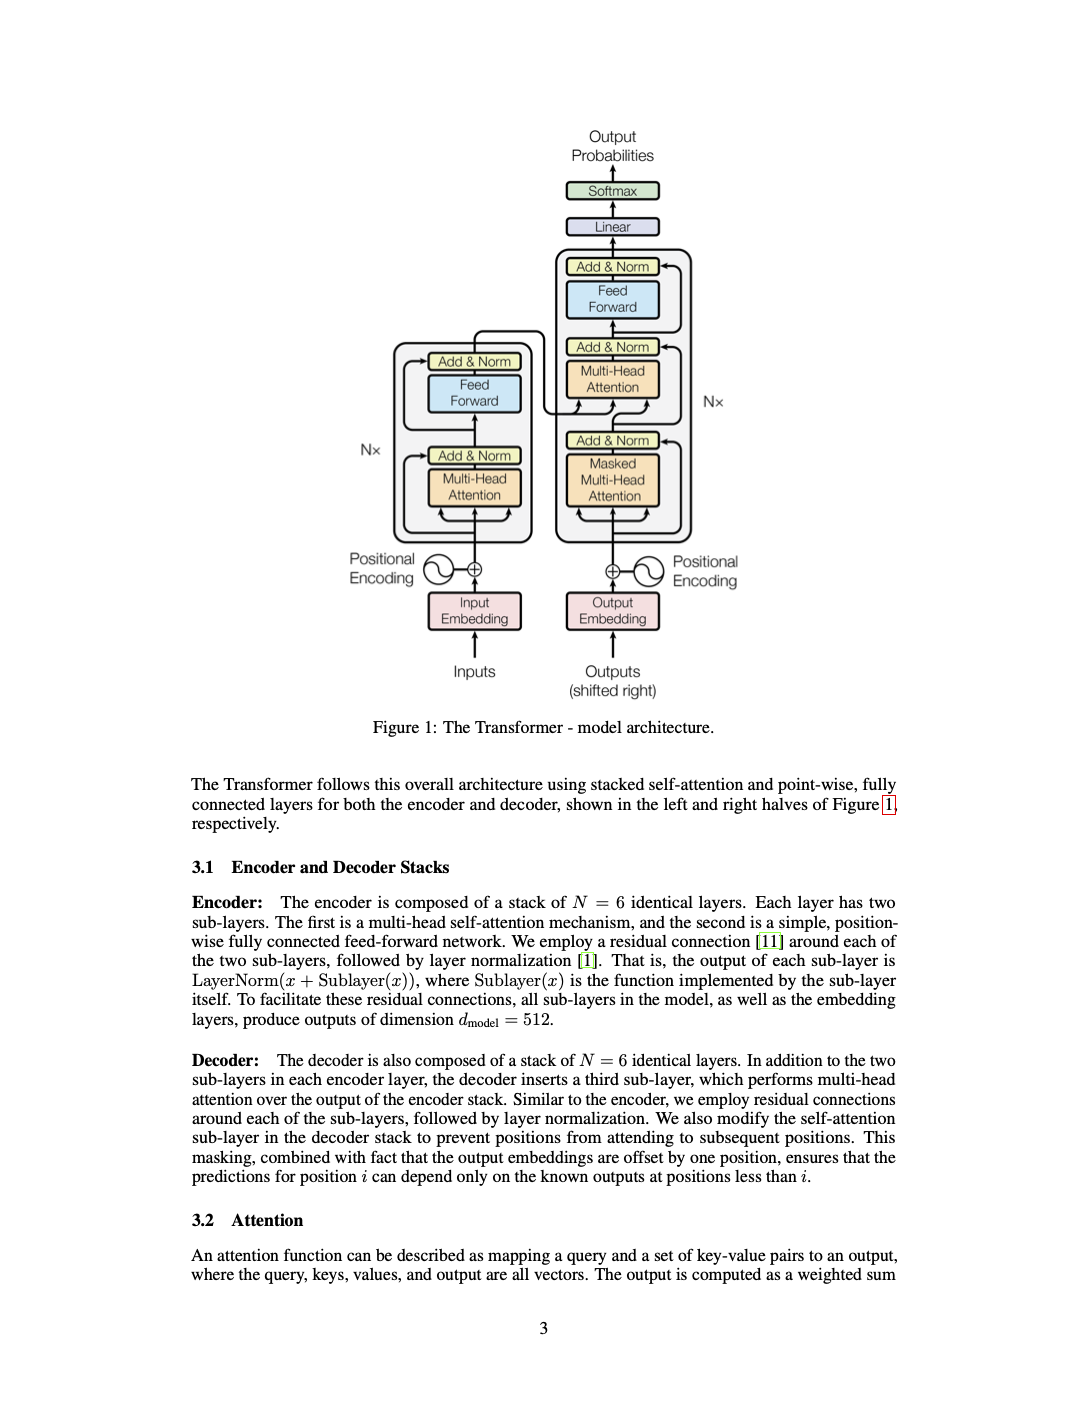

In [65]:
image

## Pooling API
calling with 'v1/embeddings' API gives following error
```
outputs=EmbeddingOutput.from_base(request_output.outputs),
...
raise ValueError("pooled_data should be a 1-D embedding vector")
```

-> recommends to use 'pooling' API
* https://github.com/vllm-project/vllm/issues/11446
* https://github.com/vllm-project/vllm/pull/11457

```
we should now use LLM.encode() for reward models while LLM.embed() should be used for embedding models (not reward models
```

In [4]:
# url = f"{VLLM_ENDPOINT}/v1/embeddings"
url = f"{VLLM_ENDPOINT}/pooling" # Use Pooling API

## single text embedding (query/passage)

In [5]:
query = "Transformer model architecture"

In [36]:
response = requests.post(
    url,
    json={
        "model": MODEL,
        "input": f"Query: {query}",
        "encoding_format": "float",
    },
)
response.raise_for_status()
response_json = response.json()

In [38]:
embedding = response_json['data'][0]['data']
text_embedding = np.array(embedding)
print(text_embedding.shape)
print(text_embedding[0][:40])

(5, 2048)
[ 0.02770996 -0.453125   -0.00460815  0.28515625 -0.04711914 -0.09765625
 -0.22558594 -0.03125    -0.17871094  0.34179688 -0.5703125   0.10791016
  0.01403809  0.14160156 -0.33007812 -0.04223633  0.20214844 -0.07470703
  0.5703125  -0.40039062 -0.05078125  0.08398438 -0.07080078 -0.13183594
  0.18457031 -0.53125    -0.09960938  0.07910156  0.13183594 -0.06347656
 -0.20214844  0.16601562  0.12597656 -0.25       -0.57421875 -0.23828125
  0.04614258 -0.24121094  0.00595093  0.21191406]


In [39]:
# Message-based Results
messages = [
    {"role": "user", "content": f"Query: {query}"}
]
response = requests.post(
    url,
    json={
        "model": MODEL,
        "messages": messages,
        "encoding_format": "float",
    },
)
response.raise_for_status()
response_json = response.json()

In [40]:
embedding = response_json['data'][0]['data']
chat_embedding = np.array(embedding)
print(chat_embedding.shape)
print(chat_embedding[0][:40])

(21, 2048)
[-0.06933594 -0.50390625  0.04833984  0.2734375  -0.02001953 -0.10058594
 -0.22949219 -0.07519531 -0.08642578  0.28125    -0.54296875  0.13085938
 -0.01452637  0.16210938 -0.296875   -0.01708984  0.34765625 -0.08447266
  0.48046875 -0.42382812 -0.01293945  0.14746094 -0.01611328 -0.16308594
  0.16503906 -0.51953125 -0.04223633  0.13574219  0.10595703 -0.00823975
 -0.20117188  0.11328125  0.14257812 -0.17480469 -0.6015625  -0.28320312
 -0.00543213 -0.23632812 -0.08154297  0.18164062]


In [ ]:
text_embedding_pooled = text_embedding.mean(axis=0)
print(text_embedding_pooled.shape)

chat_embedding_pooled = chat_embedding.mean(axis=0)
print(chat_embedding_pooled.shape)

pair_sim = cosine_similarity(
    np.expand_dims(text_embedding_pooled, 0),
    np.expand_dims(chat_embedding_pooled, 0)
)[0][0]

random_sim = cosine_similarity(
    np.expand_dims(text_embedding_pooled, 0),
    np.random.randn(1,2048)
)[0][0]

# Pair: 0.896 Random: -0.022
print("Pair: {:.3f} Random: {:.3f}".format(pair_sim, random_sim))

(2048,)
(2048,)
Pair: 0.896 Random: -0.022


## single image embedding

In [54]:
def img_to_base64(img: Image.Image, format="PNG"):
    buffer = BytesIO()
    upper_half.save(buffer, format=format)         # or format="JPEG"
    buffer.seek(0)

    # 3. Base64-encode
    b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return b64

In [55]:
image_format = "png"
image_base64 = img_to_base64(upper_half, format="PNG")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{image_base64}",
                },
            }
        ],
    }
]


In [56]:
response = requests.post(
    url,
    json={
        "model": MODEL,
        "messages": messages,
        "encoding_format": "float",
    },
)
response.raise_for_status()
response_json = response.json()

In [57]:
print(response_json.keys())
response_json['data'][0].keys()

dict_keys(['id', 'object', 'created', 'model', 'data', 'usage'])


dict_keys(['index', 'object', 'data'])

In [60]:
embedding = response_json['data'][0]['data']
image_embedding = np.array(embedding)
print(image_embedding.shape)

(993, 2048)


In [63]:
image_embedding_pooled = image_embedding.mean(axis=0)

text_sim = cosine_similarity(
    np.expand_dims(text_embedding_pooled, 0),
    np.expand_dims(image_embedding_pooled, 0)
)[0][0]

chat_sim = cosine_similarity(
    np.expand_dims(chat_embedding_pooled, 0),
    np.expand_dims(image_embedding_pooled, 0)
)[0][0]

print("Image vs Text: {:.3f} Image vs Chat: {:.3f}".format(text_sim, chat_sim))

Image vs Text: 0.562 Image vs Chat: 0.603


## text + image embedding
* embedding performance in this config is not guaranteed

In [73]:
caption = "Figure 1: The Tranformer - model architecture"

messages = [
    {
        "role": "user",
        "content": [
            {
                'type': 'text',
                'text': caption  
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{image_base64}",
                },
            },
            # {
            #     'type': 'text',
            #     'text': caption  
            # }
        ],
    }
]


In [74]:
response = requests.post(
    url,
    json={
        "model": MODEL,
        "messages": messages,
        "encoding_format": "float",
    },
)
response.raise_for_status()
response_json = response.json()

In [75]:
embedding = response_json['data'][0]['data']
image_with_caption_embedding = np.array(embedding)
print(image_with_caption_embedding.shape)

(1003, 2048)


In [76]:
image_with_caption_embedding_pooled = image_with_caption_embedding.mean(axis=0)

# image vs image with caption
pair_sim = cosine_similarity(
    np.expand_dims(image_embedding_pooled, 0),
    np.expand_dims(image_with_caption_embedding_pooled, 0)
)[0][0]
print("Img vs Img+Caption: {:.3f}".format(pair_sim))

Img vs Img+Caption: 0.963


In [ ]:
text_sim = cosine_similarity(
    np.expand_dims(text_embedding_pooled, 0),
    np.expand_dims(image_with_caption_embedding_pooled, 0)
)[0][0]

chat_sim = cosine_similarity(
    np.expand_dims(chat_embedding_pooled, 0),
    np.expand_dims(image_with_caption_embedding_pooled, 0)
)[0][0]

# Single Image: Image vs Text: 0.562 Image vs Chat: 0.603
# Image with Caption: Image vs Text: 0.648 Image vs Chat: 0.680
print("Image vs Text: {:.3f} Image vs Chat: {:.3f}".format(text_sim, chat_sim))

Image vs Text: 0.648 Image vs Chat: 0.680


## pool & normalize test

In [7]:
response = requests.post(
    url,
    json={
        "model": MODEL,
        "input": [
            f"Query: {query}",
            f"Query: {query} extra",
        ],
        "encoding_format": "float",
    },
)
response.raise_for_status()
response_json = response.json()

In [24]:
def pool_and_normalize(x: np.array):
    pooled_output = np.sum(x, axis=0, dtype=np.float32) / x.shape[0]
    normalized_output = pooled_output / np.linalg.norm(pooled_output, ord=2)
    return normalized_output

embeddings = []
for result in response_json['data']:
    x = np.array(result['data'])
    x = pool_and_normalize(x)
    embeddings.append(x)
embeddings = np.stack(embeddings)
print(embeddings.shape)

(2, 2048)
